## Report
by Dileepa Joseph Jayamanne <br>
Student ID: 22031359<br>

### Introduction
Write about what is sentiment analysis, the dataset,  the task, the reason for choosing a subset (balanced) and about Bert based model and Pytorch work flow.

### Organisation of sections

In Section 1, optimal hyperparameter seach was made. Here, optimal batch size and learning rate were found using 3 epochs for a small subset.

Then, a large subset of data (100,000 records) was split into 70:10:20 ratios of train, validation and test splits. In Section 2, Bert based classifier with optimal batch size and learning rate was trained on this large subset of data for 5 epochs that resulted a test accuracy of -----. Here, Bert base was frozen and only the head was trained.

In Section 3, an improvement for the classifer described in section 2 was made. The last two layers of the Bert based classifier were allowed to train along with the head for 5 epochs. This resulted in an imporved test accuracy -----.

In Section 4, further improvement for the classifer destribed in section 3 was made. The last 6 layers of the Bert based classifier were allowed to train along with the head for 5 epochs. This resulted in an imporved test accuracy -----.

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!pip install transformers datasets torch
!pip install optuna

# All imports
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import os
import torch
import optuna
from optuna.trial import FixedTrial
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import f1_score

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# Load the full dataset
dataset = load_dataset('sentiment140', trust_remote_code=True)
# Here, original preprocessing is applied.

# Take a small subset (e.g., 10,000 samples)
subset = dataset['train'].shuffle(seed=42).select(range(10000))

# Convert to a DataFrame for easier manipulation with seaborn
subset_df = pd.DataFrame(subset)

# Extracting the relevant columns
subset_df = subset_df[['text','sentiment']]

# target: the polarity of the tweet (0 = negative, 4 = positive)
# We change this to (0 = negative,  1 = positive)
subset_df['sentiment'] = subset_df['sentiment'].replace(4, 1)

# Set display options to show the full text
pd.set_option('display.max_colwidth', None)

# Display the structure of the dataset
subset_df.head()

Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

,text,sentiment
0,why am i awake so early? damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail,0
1,watching church online because I'd be half an hour late by the time I got there,0
2,Hillsong!,1
3,is at Stafford Train Station and just watched Em's train pull away heading southbound on the WCML,0
4,thanks everyone for the follow fridays!,1


### Inspecting sentiment labels

In [ ]:
subset_df['sentiment'].unique()

array([0, 1])

In [ ]:
# Ensure that sentiment labels are 0 or 1 or 2
assert subset_df['sentiment'].isin([0, 1]).all(), "Dataset contains invalid sentiment labels"

### Distribution of positive and negative tweets

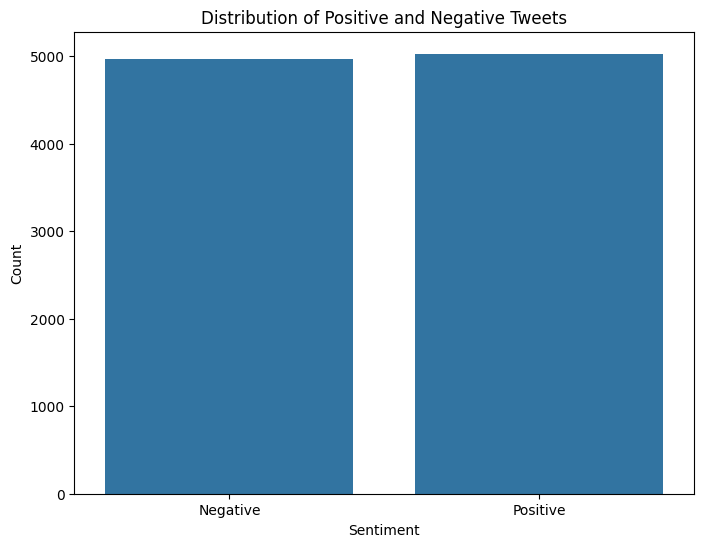

Total data records: 10000


In [ ]:
# Plot the distribution of positive and negative reviews
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=subset_df)
plt.title('Distribution of Positive and Negative Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

print(f'Total data records: {subset_df.shape[0]}')

### Viewing a sample of positive and negative tweets

In [ ]:
# Extracting positive reviews
positive_reviews = subset_df[subset_df['sentiment'] == 1]

# Extracting negative reviews
negative_reviews = subset_df[subset_df['sentiment'] == 0]

# Set display options to show the full text
pd.set_option('display.max_colwidth', None)

# Display text of five sample records
print(positive_reviews.sample(5, random_state=1))

# Display text of five sample records
print(negative_reviews.sample(5, random_state=1))

                                                                   text  \
6948                                  Listen to Hot 97 live web stream    
4068                      @rockthenroll site looks hot! nice work, man    
3716  @JackAllTimeLow I listened it on ATLSpain... it's amazing, guys.    
3894                                                         CASS WINS    
7046                                @sophiestication Good luck Sophia!    

      sentiment  
6948          1  
4068          1  
3716          1  
3894          1  
7046          1  
                                                                                                                                            text  \
5018                       @OtaliaRocks I do but at the moment im trying to do something &quot;super special&quot; for you! and Im all confused    
9330  @lechatsavant I want the Horny Manatee to come back SO BADLY.  Also S&amp;M Lincoln and the Masturbating Bear.  I MISS THEM SO DAMN MUCH.  

### Modeling: Finding the best hyper-parameters for the best model for later use

#### Experiment 01

Here, a small subset of data (10000 records) were split into 70:10:20 ratio to obtain the train, validation and test splits. The purpose of using a small dataset is to find the optimal set of hyper-parameters to use for training the model for more epochs later.

Here, 9 combinations of different learning rates [1e-5, 2e-5, 5e-5] and batch sizes [8, 16, 32] were used. In this experiment, hyper-parameter turing was done for 3 epochs per combination. Optuna library was used to search for optimal hyperparameters in this PyTorch model training workflow. To ensure that Optuna tries exactly 9 unique combinations of learning_rate and batch_size, these combinations were manually defined and then Optuna's FixedTrial class was used to iterate over them. When using FixedTrial and running multiple trials with Optuna, the DistilBertForSequenceClassification model would be re-initialized in each trial. This means that the classifier (both bias and weight) and any other model-specific parameters would be re-initialized every time a new trial is run. <br>

To ensure other model-specific parameters like classifier.bias, classifier.weight, pre-classifier.bias, and pre-classifier.weight parameters are the same across all trials, the model was initialized and its initial state was saved. Then, for each trial,  this saved state was loaded into the model before this hyper-parameter search. It was observed that optimal learning rate and batch size were 5e-5 and 8. When this initial model was evaluated on the test set, it had a ¬57% accuracy. Note that here Distilbert base model was frozen and only attached head was finetuned.

In [ ]:
# Below code is an experiment. If it works, remove the above cell

In [ ]:
# Split the 80% of subset into train and 20% into test sets
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=42)

# Split the train set again into train and validation sets: val_df size is 1/8 of input data
# 1/8 of 80% is 10%
# Therefore, ratio of train_df:val_df:test_df is 70:10:20

train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)

# Check the resulting sizes
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Tokenize the data
base_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)

# Create a custom dataset class for pre-processing
class Tweet_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['sentiment'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Pre-processing the data
train_dataset = Tweet_Dataset(train_df, tokenizer)
val_dataset = Tweet_Dataset(val_df, tokenizer)
test_dataset = Tweet_Dataset(test_df, tokenizer)

num_workers = 2
accumulation_steps = 4
epochs = 3
save_path = '/content/drive/My Drive/Colab Notebooks/Advanced Research Methods in DS/A3_data/initial_best_model2.pth'

# Finding the best hyper-parameters of the best model

# Define the 9 unique combinations of learning_rate and batch_size
param_combinations = [
    {'learning_rate': 1e-5, 'batch_size': 8},
    {'learning_rate': 1e-5, 'batch_size': 16},
    {'learning_rate': 1e-5, 'batch_size': 32},
    {'learning_rate': 2e-5, 'batch_size': 8},
    {'learning_rate': 2e-5, 'batch_size': 16},
    {'learning_rate': 2e-5, 'batch_size': 32},
    {'learning_rate': 5e-5, 'batch_size': 8},
    {'learning_rate': 5e-5, 'batch_size': 16},
    {'learning_rate': 5e-5, 'batch_size': 32},
]

# Initialize and save the initial model state
base_model = 'distilbert-base-uncased'
initial_model = DistilBertForSequenceClassification.from_pretrained(base_model, num_labels=2)

# Save the initial state of the classifier head
initial_state = {
    'classifier.weight': initial_model.classifier.weight.clone(),
    'classifier.bias': initial_model.classifier.bias.clone()
}

# Function to reset the model's classifier head to the initial state
def reset_classifier(model, initial_state):
    model.classifier.weight.data = initial_state['classifier.weight'].clone()
    model.classifier.bias.data = initial_state['classifier.bias'].clone()

# Function to train and evaluate the model
def train_and_evaluate_model(trial):
    learning_rate = trial.suggest_categorical('learning_rate', [1e-5, 2e-5, 5e-5])
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])

    # Initialize the model and reset classifier head
    model = DistilBertForSequenceClassification.from_pretrained(base_model, num_labels=2)
    reset_classifier(model, initial_state)

    # Freeze all the parameters in DistilBERT
    for param in model.distilbert.parameters():
        param.requires_grad = False

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss()
    model.to('cuda')

    best_accuracy = 0.0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        for i, batch in enumerate(tqdm(train_loader)):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                torch.cuda.empty_cache()  # Clear GPU cache to manage memory better

            _, predicted = torch.max(outputs.logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

        accuracy = correct / total
        f1 = f1_score(all_labels, all_preds, average='weighted')

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to('cuda')
                attention_mask = batch['attention_mask'].to('cuda')
                labels = batch['labels'].to('cuda')

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                _, predicted = torch.max(logits, dim=1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), save_path)

        model.train()  # Set the model back to training mode after evaluation

    return best_accuracy

# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='maximize')

# Use FixedTrial to run the predefined combinations
for params in param_combinations:
    trial = FixedTrial(params)
    study.enqueue_trial(params)  # Add the trial to the study

study.optimize(train_and_evaluate_model, n_trials=9)

print('Best trial:', study.best_trial.params)

Train set size: 7000
Validation set size: 1000
Test set size: 2000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2024-08-07 16:14:58,646] A new study created in memory with name: no-name-dee63cf5-4171-4df6-9d00-066064f9c786
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 875/875 [02:00<00:00,  7.28it/s]
[I 2024-08-07 16:21:51,955] Trial 0 finished with value: 0.535 and parameters: {'learning_rate': 1e-05, 'batch_size': 8}. Best is 

Best trial: {'learning_rate': 5e-05, 'batch_size': 8}


In [ ]:
# Evaluating this best model on test data prior to training futher
best_model = DistilBertForSequenceClassification.from_pretrained(base_model, num_labels=2)
best_model.load_state_dict(torch.load(save_path))
best_model.to('cuda')
best_model.eval()

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

correct = 0
total = 0
all_labels = []
all_preds = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"---- Initial performance of the best model on test data ----")
print(f"Accuracy on test set: {accuracy}")
print(f"F1-score on test set: {f1}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


---- Initial performance of the best model on test data ----
Accuracy on test set: 0.5655
F1-score on test set: 0.5393428592092434


### Training the best model on a large subset of tweet data

In [ ]:
# Loading a bigger subset and performing fine-tuning

# Load the full dataset
dataset = load_dataset('sentiment140', trust_remote_code=True)
# Here, original preprocessing is applied.

# Take a subset (e.g., 100,000 samples)
subset = dataset['train'].shuffle(seed=42).select(range(100000))

# Convert to a DataFrame for easier manipulation with seaborn
subset_df = pd.DataFrame(subset)

# Extracting the relevant columns
subset_df = subset_df[['text','sentiment']]

# target: the polarity of the tweet (0 = negative, 4 = positive)
# We change this to (0 = negative,  1 = positive)
subset_df['sentiment'] = subset_df['sentiment'].replace(4, 1)

# Set display options to show the full text
pd.set_option('display.max_colwidth', None)

# Display the structure of the dataset
subset_df.head()

Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

,text,sentiment
0,why am i awake so early? damn projects. super nervous for the science one. mines gunna be so lame i dont wanna fail,0
1,watching church online because I'd be half an hour late by the time I got there,0
2,Hillsong!,1
3,is at Stafford Train Station and just watched Em's train pull away heading southbound on the WCML,0
4,thanks everyone for the follow fridays!,1


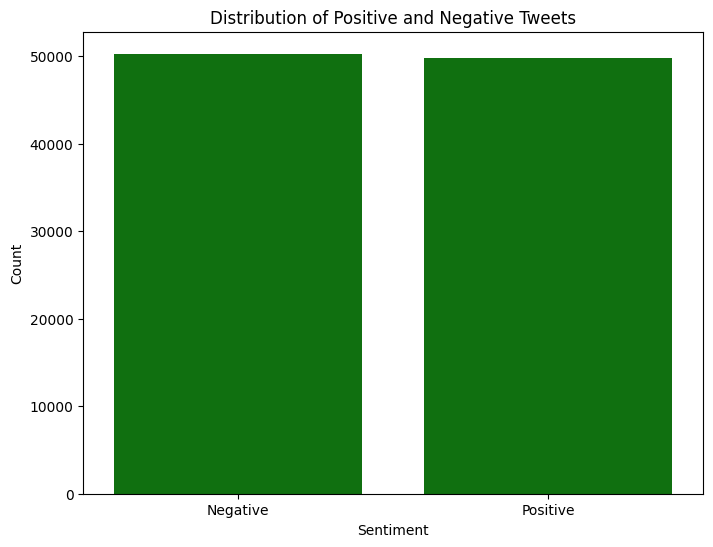

Total data records: 100000


In [ ]:
# Plot the distribution of positive and negative reviews
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=subset_df, color='green')
plt.title('Distribution of Positive and Negative Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

print(f'Total data records: {subset_df.shape[0]}')

In [ ]:
batch_size = 8        # Obtained from experiment 1
learning_rate = 5e-05 # Obtained from experiment 1

num_workers = 2
#accumulation_steps = 4
epochs = 5
save_path = '/content/drive/My Drive/Colab Notebooks/A3_data/best_model_S140.pth'
#save_path = '/content/drive/My Drive/Colab Notebooks/Advanced Research Methods in DS/A3_data/best_model_S140.pth'

In [ ]:
# Create a custom dataset class for pre-processing
class Tweet_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe['text'].tolist()
        self.labels = dataframe['sentiment'].tolist()
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# Split the 80% of subset into train and 20% into test sets
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=42)
# Split the train set again into train and validation sets: val_df size is 1/8 of input data
# 1/8 of 80% is 10%
# Therefore, ratio of train_df:val_df:test_df is 70:10:20
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)

# Check the resulting sizes
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

base_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)

# Adding a head on top of base_model followed by softmax layer for classification
best_model = DistilBertForSequenceClassification.from_pretrained(base_model, num_labels=2)

# Freeze all the parameters in DistilBERT
for param in best_model.distilbert.parameters():
    param.requires_grad = False

# Data pre-processing
train_dataset = Tweet_Dataset(train_df, tokenizer)
val_dataset = Tweet_Dataset(val_df, tokenizer)
test_dataset = Tweet_Dataset(test_df, tokenizer)

# Only parameters of the classifier head will be updated
optimizer = torch.optim.AdamW(best_model.classifier.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()
best_model.to('cuda')

# Fine-tuning the model
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

optimizer = torch.optim.AdamW(best_model.classifier.parameters(), lr=learning_rate)

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

best_val_accuracy = 0

for epoch in range(5):
    best_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, predicted = torch.max(outputs.logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    history['loss'].append(avg_loss)
    history['accuracy'].append(accuracy)

    best_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    val_accuracy = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = best_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            _, predicted = torch.max(outputs.logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    # Save the model if the accuracy is the best we've seen so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(best_model.state_dict(), save_path)

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    #print(f'Epoch {epoch + 1}/{5}')
    #print(f'Training Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.4f}')
    #print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f} | Training Accuracy: {accuracy:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")


Train set size: 70000
Validation set size: 10000
Test set size: 20000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 8750/8750 [21:37<00:00,  6.74it/s]


Epoch 1/5 | Training Loss: 0.6566 | Training Accuracy: 0.6430 | Validation Loss: 0.6267 | Validation Accuracy: 0.6758


100%|██████████| 8750/8750 [22:08<00:00,  6.59it/s]


Epoch 2/5 | Training Loss: 0.6155 | Training Accuracy: 0.6805 | Validation Loss: 0.5987 | Validation Accuracy: 0.6889


100%|██████████| 8750/8750 [22:09<00:00,  6.58it/s]


Epoch 3/5 | Training Loss: 0.5975 | Training Accuracy: 0.6888 | Validation Loss: 0.5828 | Validation Accuracy: 0.7011


100%|██████████| 8750/8750 [22:05<00:00,  6.60it/s]


Epoch 4/5 | Training Loss: 0.5867 | Training Accuracy: 0.6980 | Validation Loss: 0.5720 | Validation Accuracy: 0.7100


100%|██████████| 8750/8750 [22:11<00:00,  6.57it/s]


Epoch 5/5 | Training Loss: 0.5806 | Training Accuracy: 0.6999 | Validation Loss: 0.5643 | Validation Accuracy: 0.7148


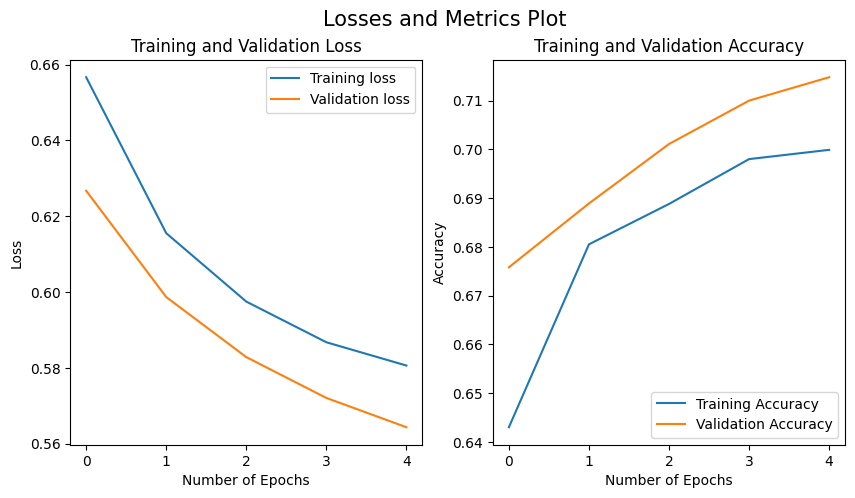

In [ ]:
# Plot training and validation history
epochs_range = range(len(history['loss']))

#plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.suptitle("Losses and Metrics Plot", fontsize=15)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['loss'], label='Training loss')
plt.plot(epochs_range, history['val_loss'], label='Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluate the model on the test data upon training for 5 epochs
print('----- Evaluating the best model on test data upon training for 5 epochs -----')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
best_model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f'Accuracy on the test set = {accuracy * 100:.2f}%')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1-Score on the test set: {f1:.4f}")


----- Evaluating the best model on test data upon training for 5 epochs -----
Accuracy on the test set = 72.29%
F1-Score on the test set: 0.7229


In [ ]:
# Print the named parameters of the DistilBERT model to understand the layer names
for name, param in best_model.named_parameters():
    print(name)

distilbert.embeddings.word_embeddings.weight
distilbert.embeddings.position_embeddings.weight
distilbert.embeddings.LayerNorm.weight
distilbert.embeddings.LayerNorm.bias
distilbert.transformer.layer.0.attention.q_lin.weight
distilbert.transformer.layer.0.attention.q_lin.bias
distilbert.transformer.layer.0.attention.k_lin.weight
distilbert.transformer.layer.0.attention.k_lin.bias
distilbert.transformer.layer.0.attention.v_lin.weight
distilbert.transformer.layer.0.attention.v_lin.bias
distilbert.transformer.layer.0.attention.out_lin.weight
distilbert.transformer.layer.0.attention.out_lin.bias
distilbert.transformer.layer.0.sa_layer_norm.weight
distilbert.transformer.layer.0.sa_layer_norm.bias
distilbert.transformer.layer.0.ffn.lin1.weight
distilbert.transformer.layer.0.ffn.lin1.bias
distilbert.transformer.layer.0.ffn.lin2.weight
distilbert.transformer.layer.0.ffn.lin2.bias
distilbert.transformer.layer.0.output_layer_norm.weight
distilbert.transformer.layer.0.output_layer_norm.bias
distil

In [ ]:
# Viewing the last two layers
all_layers = best_model.distilbert.transformer.layer[:]
print(all_layers)

ModuleList(
  (0-5): 6 x TransformerBlock(
    (attention): MultiHeadSelfAttention(
      (dropout): Dropout(p=0.1, inplace=False)
      (q_lin): Linear(in_features=768, out_features=768, bias=True)
      (k_lin): Linear(in_features=768, out_features=768, bias=True)
      (v_lin): Linear(in_features=768, out_features=768, bias=True)
      (out_lin): Linear(in_features=768, out_features=768, bias=True)
    )
    (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (ffn): FFN(
      (dropout): Dropout(p=0.1, inplace=False)
      (lin1): Linear(in_features=768, out_features=3072, bias=True)
      (lin2): Linear(in_features=3072, out_features=768, bias=True)
      (activation): GELUActivation()
    )
    (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  )
)


In [ ]:
# Viewing the last two layers
last_two_layers = best_model.distilbert.transformer.layer[-2:]

# Viewing the parameters of the last two layers
for layer in last_two_layers:
    print(f"Layer: {layer}")
    for param in layer.parameters():
        print(f"No of parameters: {len(param)}")

Layer: TransformerBlock(
  (attention): MultiHeadSelfAttention(
    (dropout): Dropout(p=0.1, inplace=False)
    (q_lin): Linear(in_features=768, out_features=768, bias=True)
    (k_lin): Linear(in_features=768, out_features=768, bias=True)
    (v_lin): Linear(in_features=768, out_features=768, bias=True)
    (out_lin): Linear(in_features=768, out_features=768, bias=True)
  )
  (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (ffn): FFN(
    (dropout): Dropout(p=0.1, inplace=False)
    (lin1): Linear(in_features=768, out_features=3072, bias=True)
    (lin2): Linear(in_features=3072, out_features=768, bias=True)
    (activation): GELUActivation()
  )
  (output_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
)
No of parameters: 768
No of parameters: 768
No of parameters: 768
No of parameters: 768
No of parameters: 768
No of parameters: 768
No of parameters: 768
No of parameters: 768
No of parameters: 768
No of parameters: 768
No of parameters: 3

### Training the best model on a large subset of tweet data - v2

Eventough Distilbert model is frozen, here its last two layers were trained along with the classifier head. The optimizer is set to train the last two layers with a lower learning rate and the classifier head with the specified learning rate.  

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datasets import load_dataset

# Function to reset the classifier
def reset_classifier(model, initial_state):
    model.classifier.weight.data = initial_state['classifier.weight'].clone()
    model.classifier.bias.data = initial_state['classifier.bias'].clone()

# Loading the full dataset
dataset = load_dataset('sentiment140', trust_remote_code=True)
subset = dataset['train'].shuffle(seed=42).select(range(100000))
subset_df = pd.DataFrame(subset)
subset_df = subset_df[['text', 'sentiment']]
subset_df['sentiment'] = subset_df['sentiment'].replace(4, 1)

# Split the data
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

batch_size = 8
learning_rate = 5e-05
num_workers = 2
epochs = 5
save_path = 'best_model_S140_v2.pth'

base_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)
best_model = DistilBertForSequenceClassification.from_pretrained(base_model, num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)  # Move the model to the correct device


# # Save the initial state of the classifier head
# initial_state = {
#     'classifier.weight': best_model.classifier.weight.clone(),
#     'classifier.bias': best_model.classifier.bias.clone()
# }

# reset_classifier(best_model, initial_state)

# Freeze all layers first
for param in best_model.distilbert.parameters():
    param.requires_grad = False

# Unfreeze the last 2 layers
for param in best_model.distilbert.transformer.layer[-2:].parameters():
    param.requires_grad = True

# Ensure classifier head is also trainable
for param in best_model.classifier.parameters():
    param.requires_grad = True

# Prepare datasets and data loaders
class Tweet_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        sentiment = self.data.iloc[index]['sentiment']
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(sentiment, dtype=torch.long)
        }

train_dataset = Tweet_Dataset(train_df, tokenizer)
val_dataset = Tweet_Dataset(val_df, tokenizer)
test_dataset = Tweet_Dataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

optimizer = torch.optim.AdamW([
    {'params': best_model.distilbert.transformer.layer[-2:].parameters(), 'lr': learning_rate / 10},
    {'params': best_model.classifier.parameters(), 'lr': learning_rate}
])

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

best_val_accuracy = 0

for epoch in range(epochs):
    best_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, predicted = torch.max(outputs.logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    history['loss'].append(avg_loss)
    history['accuracy'].append(accuracy)

    best_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = best_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            _, predicted = torch.max(outputs.logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(best_model.state_dict(), save_path)

    print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f} | Training Accuracy: {accuracy:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

print('Best Validation Accuracy:', best_val_accuracy)


Train set size: 70000
Validation set size: 10000
Test set size: 20000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 8750/8750 [08:09<00:00, 17.88it/s]


Epoch 1/5 | Training Loss: 0.4557 | Training Accuracy: 0.7848 | Validation Loss: 0.4138 | Validation Accuracy: 0.8106


100%|██████████| 8750/8750 [08:03<00:00, 18.09it/s]


Epoch 2/5 | Training Loss: 0.4082 | Training Accuracy: 0.8157 | Validation Loss: 0.4133 | Validation Accuracy: 0.8104


100%|██████████| 8750/8750 [08:04<00:00, 18.06it/s]


Epoch 3/5 | Training Loss: 0.3867 | Training Accuracy: 0.8257 | Validation Loss: 0.3995 | Validation Accuracy: 0.8197


100%|██████████| 8750/8750 [08:03<00:00, 18.09it/s]


Epoch 4/5 | Training Loss: 0.3684 | Training Accuracy: 0.8365 | Validation Loss: 0.3876 | Validation Accuracy: 0.8260


100%|██████████| 8750/8750 [08:04<00:00, 18.06it/s]


Epoch 5/5 | Training Loss: 0.3503 | Training Accuracy: 0.8458 | Validation Loss: 0.3928 | Validation Accuracy: 0.8242
Best Validation Accuracy: 0.826


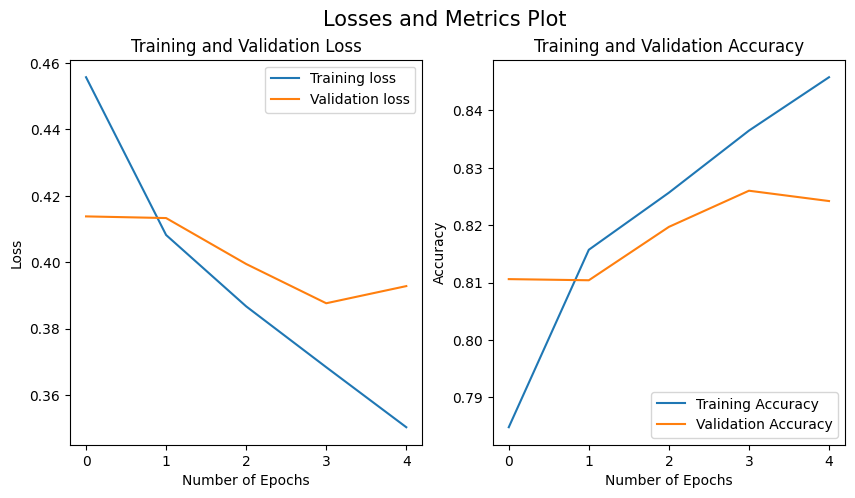

In [ ]:
# Plot training and validation history
epochs_range = range(len(history['loss']))

#plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.suptitle("Losses and Metrics Plot", fontsize=15)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['loss'], label='Training loss')
plt.plot(epochs_range, history['val_loss'], label='Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluate the model on the test data upon training for 5 epochs
print('----- Evaluating the best model on test data upon training for 5 epochs -----')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
best_model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f'Accuracy on the test set = {accuracy * 100:.2f}%')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1-Score on the test set: {f1:.4f}")


----- Evaluating the best model on test data upon training for 5 epochs -----
Accuracy on the test set = 82.72%
F1-Score on the test set: 0.8269


### Training the best model on a large subset of tweet data - v3


In [4]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datasets import load_dataset

# Loading the full dataset
dataset = load_dataset('sentiment140', trust_remote_code=True)
subset = dataset['train'].shuffle(seed=42).select(range(100000))
subset_df = pd.DataFrame(subset)
subset_df = subset_df[['text', 'sentiment']]
subset_df['sentiment'] = subset_df['sentiment'].replace(4, 1)

# Split the data
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

batch_size = 8
learning_rate = 5e-05
num_workers = 2
epochs = 10
save_path = 'best_model_S140_v3.pth'

base_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)
best_model = DistilBertForSequenceClassification.from_pretrained(base_model, num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)  # Move the model to the correct device

# Freeze all layers first
for param in best_model.distilbert.parameters():
    param.requires_grad = False

# Unfreeze the last 4 layers
for param in best_model.distilbert.transformer.layer[-2:].parameters():
    param.requires_grad = True

# Ensure classifier head is also trainable
for param in best_model.classifier.parameters():
    param.requires_grad = True

# Prepare datasets and data loaders
class Tweet_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        sentiment = self.data.iloc[index]['sentiment']
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(sentiment, dtype=torch.long)
        }

train_dataset = Tweet_Dataset(train_df, tokenizer)
val_dataset = Tweet_Dataset(val_df, tokenizer)
test_dataset = Tweet_Dataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

optimizer = torch.optim.AdamW([
    {'params': best_model.distilbert.transformer.layer[-2:].parameters(), 'lr': learning_rate / 10},
    {'params': best_model.classifier.parameters(), 'lr': learning_rate}
])

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

best_val_accuracy = 0

for epoch in range(epochs):
    best_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        _, predicted = torch.max(outputs.logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    history['loss'].append(avg_loss)
    history['accuracy'].append(accuracy)

    best_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')

            outputs = best_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            _, predicted = torch.max(outputs.logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(best_model.state_dict(), save_path)

    print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f} | Training Accuracy: {accuracy:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

print('Best Validation Accuracy:', best_val_accuracy)


Generating train split:   0%|          | 0/1600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/498 [00:00<?, ? examples/s]

Train set size: 70000
Validation set size: 10000
Test set size: 20000


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 8750/8750 [07:25<00:00, 19.64it/s]


Epoch 1/10 | Training Loss: 0.4546 | Training Accuracy: 0.7875 | Validation Loss: 0.4170 | Validation Accuracy: 0.8066


100%|██████████| 8750/8750 [07:24<00:00, 19.69it/s]


Epoch 2/10 | Training Loss: 0.4088 | Training Accuracy: 0.8144 | Validation Loss: 0.3956 | Validation Accuracy: 0.8194


100%|██████████| 8750/8750 [07:24<00:00, 19.68it/s]


Epoch 3/10 | Training Loss: 0.3866 | Training Accuracy: 0.8259 | Validation Loss: 0.3854 | Validation Accuracy: 0.8266


100%|██████████| 8750/8750 [07:23<00:00, 19.74it/s]


Epoch 4/10 | Training Loss: 0.3665 | Training Accuracy: 0.8370 | Validation Loss: 0.3877 | Validation Accuracy: 0.8258


100%|██████████| 8750/8750 [07:23<00:00, 19.72it/s]


Epoch 5/10 | Training Loss: 0.3504 | Training Accuracy: 0.8459 | Validation Loss: 0.3840 | Validation Accuracy: 0.8291


100%|██████████| 8750/8750 [07:23<00:00, 19.75it/s]


Epoch 6/10 | Training Loss: 0.3321 | Training Accuracy: 0.8546 | Validation Loss: 0.3862 | Validation Accuracy: 0.8287


100%|██████████| 8750/8750 [07:23<00:00, 19.74it/s]


Epoch 7/10 | Training Loss: 0.3152 | Training Accuracy: 0.8636 | Validation Loss: 0.3970 | Validation Accuracy: 0.8267


100%|██████████| 8750/8750 [07:23<00:00, 19.74it/s]


Epoch 8/10 | Training Loss: 0.2966 | Training Accuracy: 0.8733 | Validation Loss: 0.4017 | Validation Accuracy: 0.8279


100%|██████████| 8750/8750 [07:23<00:00, 19.74it/s]


Epoch 9/10 | Training Loss: 0.2762 | Training Accuracy: 0.8824 | Validation Loss: 0.4134 | Validation Accuracy: 0.8284


100%|██████████| 8750/8750 [07:22<00:00, 19.78it/s]


Epoch 10/10 | Training Loss: 0.2566 | Training Accuracy: 0.8927 | Validation Loss: 0.4319 | Validation Accuracy: 0.8282
Best Validation Accuracy: 0.8291


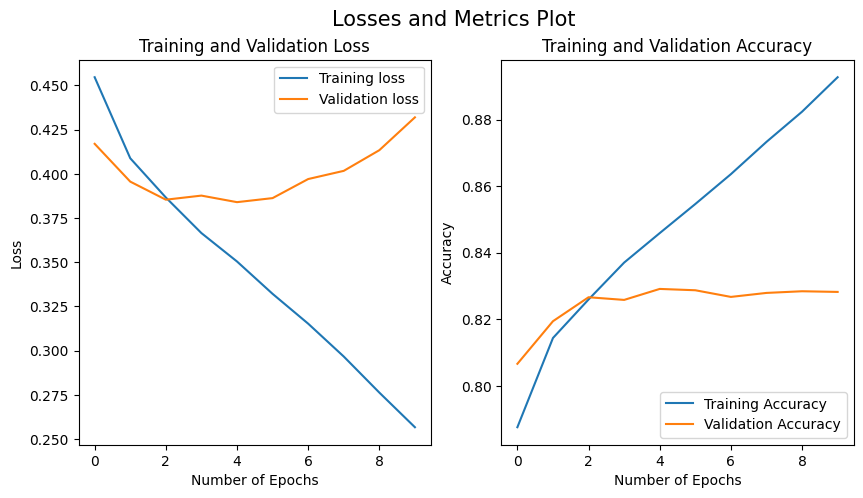

In [5]:
# Plot training and validation history
epochs_range = range(len(history['loss']))

#plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.suptitle("Losses and Metrics Plot", fontsize=15)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['loss'], label='Training loss')
plt.plot(epochs_range, history['val_loss'], label='Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [6]:
# Evaluate the model on the test data upon training for 5 epochs
print('----- Evaluating the best model on test data upon training for 5 epochs -----')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
best_model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f'Accuracy on the test set = {accuracy * 100:.2f}%')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1-Score on the test set: {f1:.4f}")


----- Evaluating the best model on test data upon training for 5 epochs -----
Accuracy on the test set = 82.60%
F1-Score on the test set: 0.8260


### Experiment 4:
Training the best model on a large subset of tweet data - v4

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AutoTokenizer, get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from datasets import load_dataset

# Loading the full dataset
dataset = load_dataset('sentiment140', trust_remote_code=True)
subset = dataset['train'].shuffle(seed=42).select(range(100000))
subset_df = pd.DataFrame(subset)
subset_df = subset_df[['text', 'sentiment']]
subset_df['sentiment'] = subset_df['sentiment'].replace(4, 1)

# Split the data
train_df, test_df = train_test_split(subset_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

batch_size = 8
learning_rate = 5e-05
num_workers = 2
epochs = 10
save_path = 'best_model_S140_v3.pth'

base_model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(base_model)
best_model = DistilBertForSequenceClassification.from_pretrained(base_model, num_labels=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model.to(device)  # Move the model to the correct device

# Freeze all layers first
for param in best_model.distilbert.parameters():
    param.requires_grad = False

# Unfreeze the last 6 layers
for param in best_model.distilbert.transformer.layer[-6:].parameters():
    param.requires_grad = True

# Add dropout to the classifier head
best_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(0.3),  # 30% dropout rate, can be tuned
    best_model.classifier
)

# Ensure classifier head is trainable
for param in best_model.classifier.parameters():
    param.requires_grad = True

# Prepare datasets and data loaders
class Tweet_Dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        sentiment = self.data.iloc[index]['sentiment']
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(sentiment, dtype=torch.long)
        }

train_dataset = Tweet_Dataset(train_df, tokenizer)
val_dataset = Tweet_Dataset(val_df, tokenizer)
test_dataset = Tweet_Dataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

optimizer = torch.optim.AdamW([
    {'params': best_model.distilbert.transformer.layer[-6:].parameters(), 'lr': learning_rate / 10},
    {'params': best_model.classifier.parameters(), 'lr': learning_rate}
])

# Learning rate scheduler
total_steps = len(train_loader) * epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps)

history = {
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

best_val_accuracy = 0

for epoch in range(epochs):
    best_model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        optimizer.step()
        scheduler.step()  # Update learning rate
        optimizer.zero_grad()

        _, predicted = torch.max(outputs.logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total
    history['loss'].append(avg_loss)
    history['accuracy'].append(accuracy)

    best_model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = best_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            _, predicted = torch.max(outputs.logits, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(best_model.state_dict(), save_path)

    print(f"Epoch {epoch + 1}/{epochs} | Training Loss: {avg_loss:.4f} | Training Accuracy: {accuracy:.4f} | Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

print('Best Validation Accuracy:', best_val_accuracy)


Train set size: 70000
Validation set size: 10000
Test set size: 20000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 8750/8750 [13:37<00:00, 10.70it/s]


Epoch 1/10 | Training Loss: 0.4969 | Training Accuracy: 0.7461 | Validation Loss: 0.4052 | Validation Accuracy: 0.8174


100%|██████████| 8750/8750 [13:24<00:00, 10.88it/s]


Epoch 2/10 | Training Loss: 0.3788 | Training Accuracy: 0.8331 | Validation Loss: 0.3756 | Validation Accuracy: 0.8339


100%|██████████| 8750/8750 [13:25<00:00, 10.87it/s]


Epoch 3/10 | Training Loss: 0.3256 | Training Accuracy: 0.8607 | Validation Loss: 0.3838 | Validation Accuracy: 0.8331


100%|██████████| 8750/8750 [13:24<00:00, 10.88it/s]


Epoch 4/10 | Training Loss: 0.2746 | Training Accuracy: 0.8854 | Validation Loss: 0.4043 | Validation Accuracy: 0.8348


100%|██████████| 8750/8750 [13:23<00:00, 10.89it/s]


Epoch 5/10 | Training Loss: 0.2253 | Training Accuracy: 0.9088 | Validation Loss: 0.4301 | Validation Accuracy: 0.8295


100%|██████████| 8750/8750 [13:23<00:00, 10.89it/s]


Epoch 6/10 | Training Loss: 0.1842 | Training Accuracy: 0.9268 | Validation Loss: 0.4689 | Validation Accuracy: 0.8336


100%|██████████| 8750/8750 [13:29<00:00, 10.80it/s]


Epoch 7/10 | Training Loss: 0.1521 | Training Accuracy: 0.9416 | Validation Loss: 0.5415 | Validation Accuracy: 0.8327


100%|██████████| 8750/8750 [13:23<00:00, 10.89it/s]


Epoch 8/10 | Training Loss: 0.1292 | Training Accuracy: 0.9506 | Validation Loss: 0.5654 | Validation Accuracy: 0.8341


 17%|█▋        | 1519/8750 [02:19<10:57, 10.99it/s]

In [ ]:
# Plot training and validation history
epochs_range = range(len(history['loss']))

#plt.style.use("dark_background")
plt.figure(figsize=(10, 5))
plt.suptitle("Losses and Metrics Plot", fontsize=15)
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history['loss'], label='Training loss')
plt.plot(epochs_range, history['val_loss'], label='Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

In [ ]:
# Evaluate the model on the test data upon training for 5 epochs
print('----- Evaluating the best model on test data upon training for 5 epochs -----')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
best_model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = correct / total
print(f'Accuracy on the test set = {accuracy * 100:.2f}%')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1-Score on the test set: {f1:.4f}")


In [ ]:
import random
from sklearn.metrics import f1_score

print('----- Evaluating the best model on test data upon training for 10 epochs -----')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
best_model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
sampled_predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        labels = batch['labels'].to('cuda')

        outputs = best_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, dim=1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

        # Store a sample of positive and negative predictions
        for i in range(len(labels)):
            if len(sampled_predictions) < 10:  # Collect 10 samples
                sampled_predictions.append({
                    'text': test_df.iloc[batch['input_ids'].cpu().numpy()[i].item()]['text'],
                    'predicted': predicted[i].cpu().item(),
                    'true': labels[i].cpu().item()
                })

accuracy = correct / total
print(f'Accuracy on the test set = {accuracy * 100:.2f}%')
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"F1-Score on the test set: {f1:.4f}")

# Display the samples
print("\nSample Predictions:")
for sample in sampled_predictions:
    label_text = "Positive" if sample['true'] == 1 else "Negative"
    pred_text = "Positive" if sample['predicted'] == 1 else "Negative"
    print(f"Text: {sample['text']}\nTrue Label: {label_text} | Predicted: {pred_text}\n")
